In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp

# Pennylane numpy
from pennylane import numpy as pnp 

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

In [3]:
# ==============================
# Global Variables
# ==============================
NUM_EVO = 0

In [4]:
def hamiltonian(coeff_x, coeff_y):
    coeffs = [coeff_x, coeff_y, 1]
    rot = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
    
    return qml.Hamiltonian(coeffs = coeffs, observables = rot)

$$
H = 
coeff_{x} \cdot(X_0) + coeff_{y} \cdot(Y_0) + 1 \cdot(Z_0)
$$

In [5]:
@qml.qnode(dev)
def circuit(coeff_parameters, dt):
    global NUM_EVO
    for evo_idx in range(NUM_EVO):
        coeff_x = coeff_parameters[0 + evo_idx * 2]
        coeff_y = coeff_parameters[1 + evo_idx * 2]
        get_hamiltonian = hamiltonian(coeff_x, coeff_y)
        
        qml.ApproxTimeEvolution(get_hamiltonian, dt, 1)
    
    return qml.density_matrix(wires=0)

In [6]:
@qml.qnode(dev)
def hadamard_test():
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires=0)

def fidelity(rho_1, rho_2):
    stage_1 = sp.linalg.sqrtm(
        sp.linalg.sqrtm(rho_1) @ rho_2 @ sp.linalg.sqrtm(rho_1)
    )
    
    return np.trace(stage_1)

def cost_function(paras):
    # print(paras)
    # print(paras[:-1])
    # print(paras[-1])
    
    coeff_parameters = paras[:-1]
    dt = paras[-1]
    
    rho_1 = circuit(coeff_parameters, dt)
    rho_2 = hadamard_test().numpy()
    
    cal_fidelity = fidelity(rho_1, rho_2).real
    
    return -cal_fidelity

def get_prev_sequence_len():
    # gets a sequence obtained from a*
    example_sequence = np.zeros(6)
    
    get_length = len(example_sequence)
    
    return get_length

In [7]:
NUM_EVO = get_prev_sequence_len()       # set number of time-evo
initial_paras = [1, 1] * NUM_EVO + [3]  # [coeff_x0, coeff_y1], ... [dt]

constraints = [
    # coeff_x
    (-1.5, 1.5),
    # coeff_y
    (-1.5, 1.5),
] * NUM_EVO + [
    # dt
    (0, 7)
]

result = sp.optimize.minimize(
    fun = cost_function, 
    x0 = initial_paras,
    method = 'L-BFGS-B',
    bounds = constraints,
    tol = 1e-12,
    options={
        'ftol': 1e-12, 
        'gtol': 1e-12
        }
    )

In [8]:
def print_result(result):
    global NUM_EVO
    print("Optimized_fidelity =", f"{-result.fun:.4f}",'\n')

    for i in range(NUM_EVO):
        print(f"num_evo: {i+1}")
        print(f"[coeff_x, coeff_y, dt] = [{result.x[0 +i*2]:.4f}, {result.x[1 +i*2]:.4f}, {result.x[-1]:.4f}]\n")
        # print(f"[dt] = {result.x[0 +i*3]:.4f}\n")

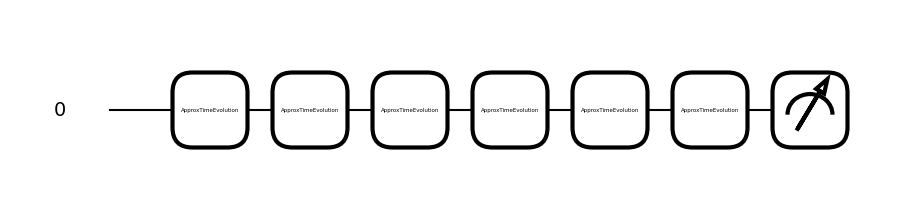

In [9]:
null = [1,1] * NUM_EVO + [1]
fig, ax = qml.draw_mpl(circuit)(null, null[-1])

In [10]:
print_result(result)

Optimized_fidelity = 0.7071 

num_evo: 1
[coeff_x, coeff_y, dt] = [0.1509, -0.5796, 0.0000]

num_evo: 2
[coeff_x, coeff_y, dt] = [1.2155, -0.8711, 0.0000]

num_evo: 3
[coeff_x, coeff_y, dt] = [0.4256, -0.7475, 0.0000]

num_evo: 4
[coeff_x, coeff_y, dt] = [0.8571, -0.7700, 0.0000]

num_evo: 5
[coeff_x, coeff_y, dt] = [0.3573, -1.0589, 0.0000]

num_evo: 6
[coeff_x, coeff_y, dt] = [0.6062, -0.6076, 0.0000]

